In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

In [4]:
file_path = "/gdrive/MyDrive/ssac_bigdata/data/bitcoin_price_1y.csv"
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

In [5]:
# 맨 뒤의 5일치 미리 빼둠
bitcoin_train_df = bitcoin_df.iloc[:361]
bitcoin_train_df.tail()

,day,price
356,2021-11-30,57828.45
357,2021-12-01,57025.79
358,2021-12-02,57229.76
359,2021-12-03,56508.48
360,2021-12-04,53713.84


In [6]:
bitcoin_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     361 non-null    object 
 1   price   361 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [7]:
#시계열은 날짜로 인식시켜야하기떄문에
#날짜로 인식시키기위해서 바꿔준다.

In [8]:
bitcoin_train_df['day'] = pd.to_datetime(bitcoin_train_df['day'])
bitcoin_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   day     361 non-null    datetime64[ns]
 1   price   361 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
# bitcoin_train_df.set_index('day', inplace=True) #렘에서만 바꾸닌 비파괴 inplace= True 해줘야 비파괴 아님
bitcoin_train_df.index = bitcoin_train_df['day'] # 복사
bitcoin_train_df.set_index('day', inplace=True)
bitcoin_train_df

,price
day,
2020-12-09,18318.87
2020-12-10,18554.15
2020-12-11,18247.76
2020-12-12,18029.36
2020-12-13,18803.44
...,...
2021-11-30,57828.45
2021-12-01,57025.79
2021-12-02,57229.76


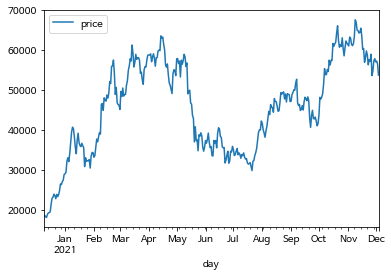

In [10]:
# 시각화
bitcoin_train_df.plot()
plt.show()

# ARIMA 모델 = AR + I + MA
AR + MA모델이었는데 I모델이 추가되었다<br/>
AR : AutoRegression, 일반적인 회귀(이전데이터들에서 학습한 내용을 가지고 예측)<br/>
MA : Moving Average, (이전데이터들의 학습에서 끝나는 게 아닌, 오차를 반영해서 예측), AR의 응용<br/>
I : Difference  , 차이값 부여

In [11]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ARIMA(p,d,q)모형은 차수 p,d,q의 값에 따라 다른이름으로 불린다.

  : p는 AR모형과 관련이 있음

  : q는 MA모형과 관련이 있음


  예1) d=0이면, ARMA(p,q)모형이라 부르고 이 모형은 정상성을 만족한다.

  예2) p=0이면, IMA(d,q)모형이라 부르고 d번 차분하면 MA(q)모형을 따르게 된다.

  예3) q=0이면, ARI(p,d)모형이라 부르며, d번 차분한 시계열이 AR(p)모형을 따르게 된다.

In [12]:
# AR -> 회귀
# MA -> 변동의 오차(가중치 반영),
# 어디까지 오차를 줄 것인가? KNN의 K값과 비슷, 3번째 파라미터 높으면 오버피팅 가능성, 적으면 언더피팅 가능성
# (AR = 2, 차분 = 1, MA = 2)로 ARIMA 모델을 학습
model = ARIMA(bitcoin_train_df.values, order=(2,1,2)) # order(안에 파라메터는 순서대로 AR ,I ,MA)
model

In [13]:
# full_output : 보고서, True면 다 보여줘
# disp(display) : 다 보여주냐?
model_fit=model.fit(trend='c', full_output = True, disp =True)
model_fit

P>|z| : 계산에서 나온 타당하지 않은 가능성, 반대되는 입장, 0.05보다 작으면 내가 맞았다는 근거(5%)<br/>
일반적으로 내가 옳다고 주장하려면 95%는 되야함. 조금 더 많이 우기면 98%(암)<br/>
앞으로 보고서를 많이 보게 될텐데 P값을 봐라. 그것을 통해 쓸지 말지 결정<br/>
내부적으로 보고서를 가지고 있는 모델이 있음(피쳐 분석). 5% 밑인지 아닌지 자동 계싼

In [14]:
# P>|z|  P = 가능성 probabiliy, 가장 중요한 값
# P값의 0은 내부적으로 문제가없다 ar ,ma를 써도된다는 의미 (0.05의 기준으로)
# p값을 보고 써도되는지 안되는지의 판단 유무를 보기떄문에 보고서를볼떄 p값을 보자

# ar : ar은 regression한 것
# ma : 오차도까지 계산해서 정확도 높임

# ar.L1, ar.L2 두 번 함
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  360
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3225.913
Method:                       css-mle   S.D. of innovations           1882.730
Date:                Fri, 10 Dec 2021   AIC                           6463.825
Time:                        05:12:51   BIC                           6487.142
Sample:                             1   HQIC                          6473.096
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.7901     99.496      0.802      0.423    -115.219     274.799
ar.L1.D.y      0.9185      0.040     23.091      0.000       0.841       0.996
ar.L2.D.y     -0.9440      0.032    -29.400      0.000      -1.007      -0.881
ma.L1.D.y     -0.9573      0.025    -38.376      0.000      -1.006      -0.908
ma.L2.D.y      0.9855      0.026     38.263      0.000       0.935       1.036
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4865           -0.9070j            1.0292           -0.1716
AR.2            0.4865           +0.9070j            1.0292            0.1716
MA.1            0.4857           -0.8825j            1.0073           -0.1699
MA.2            0.4857           +0.8825j            1.0073            0.1699
-----------------------------------------------------------------------------
"""

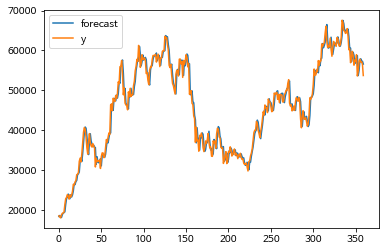

In [15]:
# 파랑 : 예측, 주황 : 실제
# 학습 데이터에 대한 예측 결과(공부한 거를 다시 테스트해봄)
# 안 맞으면 위로 가서 check
# train 데이터니까 잘 맞춤
fig = model_fit.plot_predict()

In [16]:
# 앞으로 5일치 내려다봄 (steps=5), 예측 시 보통 5일치
# 첫번째가 예측값
forcast_data = model_fit.forecast(steps =5 )
forcast_data

(array([53859.90839342, 53891.33862905, 53864.14563435, 53891.32506776,
        54023.78371803]),
 array([1882.73041766, 2611.43093677, 3183.52110652, 3707.37515166,
        4194.6159268 ]),
 array([[50169.8245822 , 57549.99220464],
        [48773.02804487, 59009.64921322],
        [47624.55892156, 60103.73234715],
        [46625.00329334, 61157.64684219],
        [45802.48757252, 62245.07986355]]))

In [17]:
bitcoin_test_df = bitcoin_df[361:]
bitcoin_test_df

,day,price
361,2021-12-05,49253.86
362,2021-12-06,49380.43
363,2021-12-07,50564.63
364,2021-12-08,50645.41
365,2021-12-09,50511.12


In [18]:
# 편차가 크다. 기간이 짧음
# test데이터 넣으니까 많이 틀림
# 49253 - 53859
pred_y = forcast_data[0] # 첫번째가 예측값
pred_y

array([53859.90839342, 53891.33862905, 53864.14563435, 53891.32506776,
       54023.78371803])

In [19]:
# array를 list로 변환
pred_y = pred_y.tolist()

In [20]:
type(pred_y)

list

In [21]:
# 시리즈
bitcoin_test_df.price.head()

361    49253.86
362    49380.43
363    50564.63
364    50645.41
365    50511.12
Name: price, dtype: float64

In [22]:
# 시리즈에서 오른쪽의 값만 가져옴(ndarray)
bitcoin_test_df.price.values

array([49253.86, 49380.43, 50564.63, 50645.41, 50511.12])

In [23]:
test_y = bitcoin_test_df.price.values
test_y = test_y.tolist()
type(test_y)

list

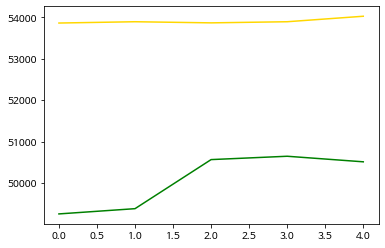

In [24]:
# 실제 : 그린, 예측 : 골드,
# 차이가 크다
plt.plot(pred_y, color = 'gold')
plt.plot(test_y, color = 'green')

In [25]:
# 하나당 2개가 들어있다. [최저예측, 최고예측]
# 최저[0], 최고[1] => 그래프로 !
# 2. dataset의 양을 3년 이상으로 늘려보자.!
forcast_data[2]

array([[50169.8245822 , 57549.99220464],
       [48773.02804487, 59009.64921322],
       [47624.55892156, 60103.73234715],
       [46625.00329334, 61157.64684219],
       [45802.48757252, 62245.07986355]])

# 비트코인 3년치 예측

In [26]:
bitcoin_df = pd.read_csv('/gdrive/MyDrive/ssac_bigdata/data/bitcoin_price_3y.csv', names = ['day', 'price'])
bitcoin_df.tail()

,day,price
1091,2021. 12. 6,49380.43
1092,2021. 12. 7,50564.63
1093,2021. 12. 8,50645.41
1094,2021. 12. 9,50511.12
1095,2021. 12. 10,47659.68


In [27]:
# 맨 뒤의 5일치 미리 빼둠
bitcoin_train_df = bitcoin_df.iloc[:1091]
bitcoin_train_df.tail()

,day,price
1086,2021. 12. 1,57025.79
1087,2021. 12. 2,57229.76
1088,2021. 12. 3,56508.48
1089,2021. 12. 4,53713.84
1090,2021. 12. 5,49253.86


In [28]:
bitcoin_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     1091 non-null   object 
 1   price   1091 non-null   float64
dtypes: float64(1), object(1)
memory usage: 17.2+ KB


In [29]:
bitcoin_train_df['day'] = pd.to_datetime(bitcoin_train_df['day'])
bitcoin_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   day     1091 non-null   datetime64[ns]
 1   price   1091 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.2 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
# bitcoin_train_df.set_index('day', inplace=True) #렘에서만 바꾸닌 비파괴 inplace= True 해줘야 비파괴 아님
bitcoin_train_df.index = bitcoin_train_df['day'] # 복사
bitcoin_train_df.set_index('day', inplace=True)
bitcoin_train_df

,price
day,
2018-12-11,3472.98
2018-12-12,3407.28
2018-12-13,3487.73
2018-12-14,3308.11
2018-12-15,3242.42
...,...
2021-12-01,57025.79
2021-12-02,57229.76
2021-12-03,56508.48


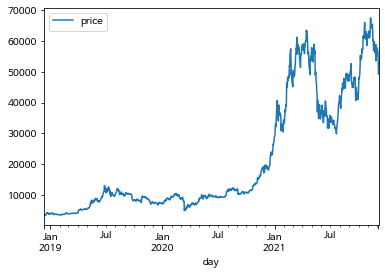

In [31]:
# 시각화
bitcoin_train_df.plot()
plt.show()

In [32]:
model = ARIMA(bitcoin_train_df.values, order=(2,1,2)) # order(안에 파라메터는 순서대로 AR ,I ,MA)
model

In [33]:
model_fit=model.fit(trend='c', full_output = True, disp =True)
model_fit

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [34]:
model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1090
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9209.892
Method:                       css-mle   S.D. of innovations           1128.035
Date:                Fri, 10 Dec 2021   AIC                          18431.785
Time:                        05:12:53   BIC                          18461.748
Sample:                             1   HQIC                         18443.125
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.9973     33.988      1.236      0.217     -24.618     108.613
ar.L1.D.y      0.8432      0.007    122.676      0.000       0.830       0.857
ar.L2.D.y     -0.9790      0.008   -116.250      0.000      -0.995      -0.962
ma.L1.D.y     -0.8702      0.004   -231.484      0.000      -0.878      -0.863
ma.L2.D.y      1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4306           -0.9144j            1.0107           -0.1799
AR.2            0.4306           +0.9144j            1.0107            0.1799
MA.1            0.4351           -0.9004j            1.0000           -0.1784
MA.2            0.4351           +0.9004j            1.0000            0.1784
-----------------------------------------------------------------------------
"""

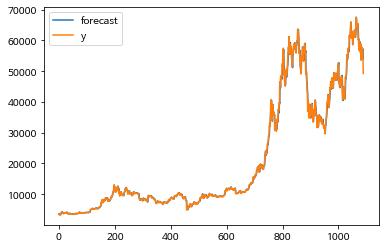

In [35]:
# 파랑 : 예측, 주황 : 실제
# train 데이터니까 잘 맞춤
fig = model_fit.plot_predict()

In [36]:
# 앞으로 5일치 내려다봄 (steps=5), 예측 시 보통 5일치
# 첫번째가 예측값
forcast_data = model_fit.forecast(steps =5 )
forcast_data

(array([49351.46028791, 49108.68415616, 48856.14015305, 48928.57238123,
        49284.5727998 ]),
 array([1128.03543391, 1573.88478024, 1917.67828481, 2222.7064436 ,
        2502.34267867]),
 array([[47140.55146417, 51562.36911165],
        [46023.92667108, 52193.44164124],
        [45097.55978089, 52614.72052522],
        [44572.14780357, 53284.99695888],
        [44380.07127263, 54189.07432697]]))

In [37]:
bitcoin_test_df = bitcoin_df[1091:]
bitcoin_test_df

,day,price
1091,2021. 12. 6,49380.43
1092,2021. 12. 7,50564.63
1093,2021. 12. 8,50645.41
1094,2021. 12. 9,50511.12
1095,2021. 12. 10,47659.68


In [38]:
pred_y = forcast_data[0] # 첫번째가 예측값
pred_y

array([49351.46028791, 49108.68415616, 48856.14015305, 48928.57238123,
       49284.5727998 ])

In [39]:
# 예측값 시각화를 위한 리스트화
pred_y = pred_y.tolist()
type(pred_y)

list

In [40]:
# 정답값 리스트화
test_y = bitcoin_test_df.price.values
test_y = test_y.tolist()
type(test_y)

list

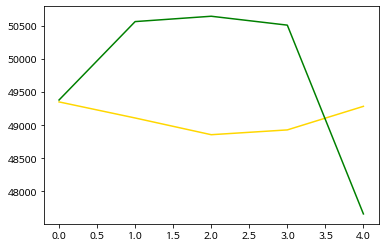

In [41]:
# 실제 : 그린, 예측 : 골드,
# 차이가 크다
plt.plot(pred_y, color = 'gold')
plt.plot(test_y, color = 'green')

In [42]:
# 하나당 2개가 들어있다. [최저예측, 최고예측]
# 최저[0], 최고[1] => 그래프로 !
# 2. dataset의 양을 3년 이상으로 늘려보자.!
forcast_data[2] # 0과 1이 들어있다.

array([[47140.55146417, 51562.36911165],
       [46023.92667108, 52193.44164124],
       [45097.55978089, 52614.72052522],
       [44572.14780357, 53284.99695888],
       [44380.07127263, 54189.07432697]])

In [43]:
# 마지막 5일의 예측 최소값
pred_y_lower = []
# 마지막 5일의 예측 최대값
pred_y_upper = []

for i in forcast_data[2]:
    pred_y_lower.append(i[0])
    pred_y_upper.append(i[1])

In [44]:
# 최저예측 최고예측까지 그리기

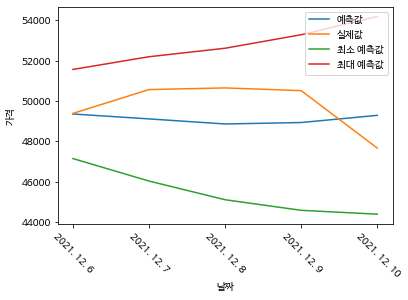

In [45]:
day = bitcoin_test_df.day.values

plt.xlabel('날짜')
plt.ylabel('가격')
plt.plot(day, pred_y)
plt.plot(day, test_y)
plt.plot(day, pred_y_lower)
plt.plot(day, pred_y_upper)
plt.legend(['예측값','실제값','최소 예측값','최대 예측값'])
plt.xticks(rotation=-45)
plt.show()

# Additive 모델 = ARIMA + 기간의 trend(경향성) : 페이스북이 만듦

In [46]:
from fbprophet import Prophet
# Prophet 예언
# DF 이름 신경쓰기
# day, price가 아닌 ds와 y로 넣어줘야함
# 경향성(년도, 요일, 계절)을 같이 봐서 hit률도 높다

1) 데이터를 Prophet에 맞도록 가공
필요한 컬럼은 ds, y 2개!(컬럼 이름을 맞춰야함)

In [47]:
# 1년치
# bitcoin_df2 = pd.read_csv(file_path, names = ['ds', 'y'])
# 3년치
bitcoin_df2 = pd.read_csv('/gdrive/MyDrive/ssac_bigdata/data/bitcoin_price_3y.csv', names = ['ds', 'y'])


In [48]:
bitcoin_df2

,ds,y
0,2018. 12. 11,3472.98
1,2018. 12. 12,3407.28
2,2018. 12. 13,3487.73
3,2018. 12. 14,3308.11
4,2018. 12. 15,3242.42
...,...,...
1091,2021. 12. 6,49380.43
1092,2021. 12. 7,50564.63
1093,2021. 12. 8,50645.41
1094,2021. 12. 9,50511.12


In [49]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, # 연도벌
                 weekly_seasonality=True, # 주차별
                 daily_seasonality=True, # 일자별
                 changepoint_prior_scale=0.5) # scale은 trend 반영 비율(높아지면 많이 반영, overfitting)

In [50]:
prophet.fit(bitcoin_df2)

In [54]:
# 5일치 예측 데이터 만들어
future_data = prophet.make_future_dataframe(periods=30, freq='d')
# 만든 걸로 예측
forecast_data = prophet.predict(future_data)
forecast_data.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1121,2022-01-05,7093.515621,48286.579849,54408.923567,6826.363962,7428.385298,6.859993,6.859993,6.859993,6.239424,6.239424,6.239424,-0.027699,-0.027699,-0.027699,-0.592870,-0.592870,-0.592870,0.0,0.0,0.0,51352.967536
1122,2022-01-06,7094.608614,48527.181108,54997.842544,6803.283189,7483.076648,6.859993,6.859993,6.859993,6.277965,6.277965,6.277965,0.016143,0.016143,0.016143,-0.598171,-0.598171,-0.598171,0.0,0.0,0.0,51634.315674
1123,2022-01-07,7095.701606,48088.796350,54514.384826,6779.939671,7504.686005,6.859993,6.859993,6.859993,6.222679,6.222679,6.222679,-0.016821,-0.016821,-0.016821,-0.620492,-0.620492,-0.620492,0.0,0.0,0.0,51249.976218
1124,2022-01-08,7096.794598,48047.037048,54400.551589,6749.333040,7525.752336,6.859993,6.859993,6.859993,6.209396,6.209396,6.209396,0.009288,0.009288,0.009288,-0.659884,-0.659884,-0.659884,0.0,0.0,0.0,51163.603768
1125,2022-01-09,7097.887590,47253.915292,54250.441133,6701.916303,7550.865171,6.859993,6.859993,6.859993,6.144189,6.144189,6.144189,0.000161,0.000161,0.000161,-0.715965,-0.715965,-0.715965,0.0,0.0,0.0,50708.652778


In [59]:
# 예측값, 최저예측, 최고예측
# hat : 예측
# - : 평균
forecast_data[['ds', 'yhat', 'yhat_lower','yhat_upper']].head(5)

,ds,yhat,yhat_lower,yhat_upper
0,2018-12-11,3625.941968,1724.726883,5488.190419
1,2018-12-12,3559.965993,1667.953634,5369.531028
2,2018-12-13,3545.499853,1746.580499,5375.790433
3,2018-12-14,3495.800062,1592.126873,5306.287205
4,2018-12-15,3485.637719,1574.739089,5399.276543


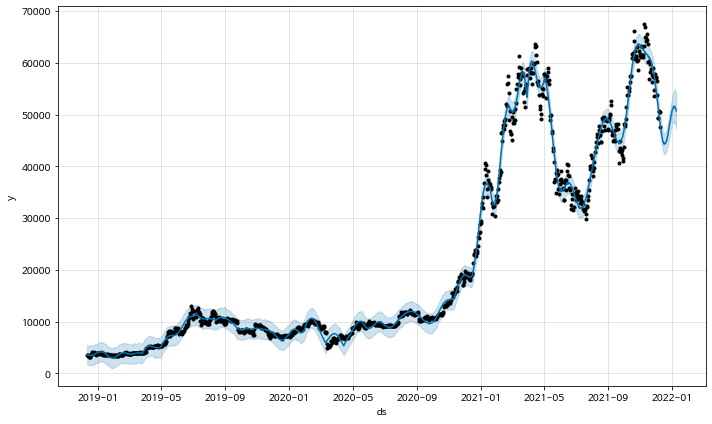

In [57]:
fig1 = prophet.plot(forecast_data)

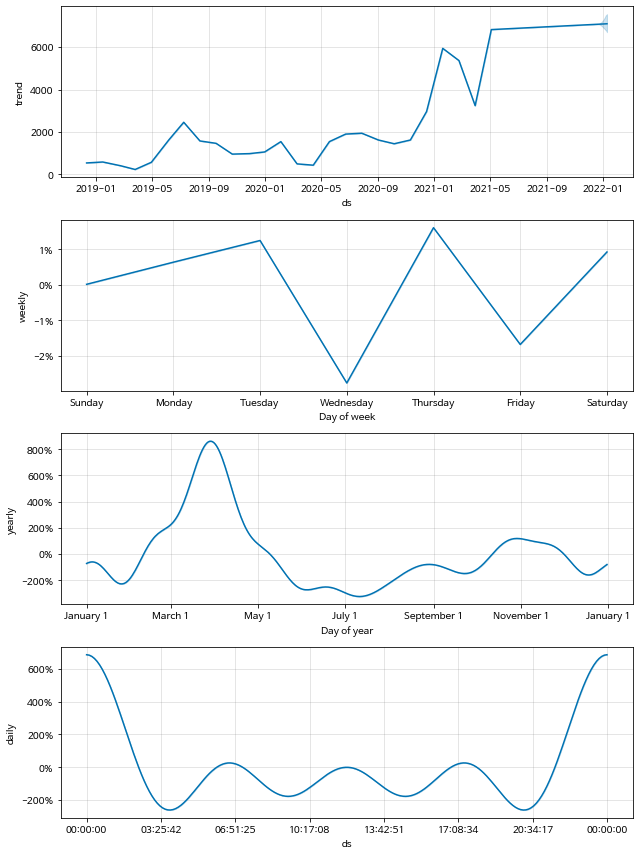

In [58]:
fig2 = prophet.plot_components(forecast_data)